# ANN

**Contents**

-  ANN (MLP) — theory, TensorFlow MLP on MNIST, PyTorch MLP, training tricks and visualization.



---


##  Setup - Common imports

In [28]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## ANN (MLP) theory
- Forward pass, loss, backprop, dropout, early stopping.

In [ ]:
# TensorFlow MLP on MNIST (quick)
from tensorflow.keras import layers, models, callbacks, datasets
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

Dividing by 255 scales the pixels to [0, 1]

In [31]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [32]:
model = models.Sequential([
    layers.Input(shape=(28*28,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
hist = model.fit(x_train[:10000], y_train[:10000], validation_split=0.15, epochs=6, batch_size=128, verbose=2)

Epoch 1/6
67/67 - 2s - 29ms/step - accuracy: 0.1113 - loss: 2.3019 - val_accuracy: 0.1073 - val_loss: 2.3013
Epoch 2/6
67/67 - 0s - 7ms/step - accuracy: 0.1136 - loss: 2.3009 - val_accuracy: 0.1073 - val_loss: 2.3012
Epoch 3/6
67/67 - 0s - 7ms/step - accuracy: 0.1136 - loss: 2.3008 - val_accuracy: 0.1073 - val_loss: 2.3010
Epoch 4/6
67/67 - 1s - 9ms/step - accuracy: 0.1136 - loss: 2.3006 - val_accuracy: 0.1073 - val_loss: 2.3010
Epoch 5/6
67/67 - 0s - 7ms/step - accuracy: 0.1136 - loss: 2.3007 - val_accuracy: 0.1073 - val_loss: 2.3009
Epoch 6/6
67/67 - 0s - 7ms/step - accuracy: 0.1136 - loss: 2.3006 - val_accuracy: 0.1073 - val_loss: 2.3009


In [35]:
print('Test eval:', model.evaluate(x_test[:2000], y_test[:2000], verbose=0))

Test eval: [2.3008522987365723, 0.11699999868869781]


In [36]:
# ===== Robust manual forward-pass activation logger (handles nested Sequential) =====
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Let's see what happens at the time of inference

In [37]:
# choose sample index
sample_idx = 100

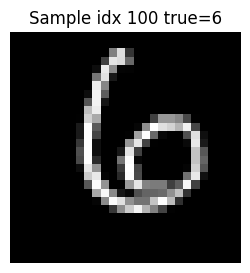

In [ ]:
# ensure x_test is flattened for the MLP (works if x_test is (N,28,28) or (N,784))
if x_test.ndim == 3:
    x_test_flat = x_test.reshape(-1, 28*28).astype('float32')
else:
    x_test_flat = x_test.astype('float32')

sample = x_test_flat[sample_idx:sample_idx+1]  # shape (1,784)
# for display, reshape back to 28x28
img = sample.reshape(28,28)
plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Sample idx {sample_idx} true={int(y_test[sample_idx])}")
plt.show()

# convert to tensor
x = tf.convert_to_tensor(sample)

In [ ]:
def plot_patch_from_vector(v, title):
    flat = v.ravel()
    N = flat.size
    side = int(np.ceil(np.sqrt(N)))
    pad = side*side - N
    grid = np.concatenate([flat, np.zeros(pad)])
    grid = grid.reshape(side, side)
    plt.figure(figsize=(3.5,3.5))
    plt.imshow(grid, cmap='viridis', aspect='equal')
    plt.title(f"{title} — reshaped {N}→{side}×{side}")
    plt.axis('off')
    plt.show()


### Collecting activations for layers (in order)

In [ ]:
# walk through layers and call them on the tensor, recording activations
activations = []
layer_infos = []

current = x
for i, layer in enumerate(model.layers):
    try:
        # Call the layer on the current tensor (this will build/call nested models too)
        current = layer(current)
    except Exception as e:
        # If a layer expects additional args (rare), try calling in training=False mode or skip
        try:
            current = layer(current, training=False)
        except Exception as e2:
            print(f"Skipping layer call for {layer.name} due to: {e2}")
            break

    # convert activation to numpy for plotting (if eager tensor)
    try:
        act_np = current.numpy()
    except Exception:
        act_np = np.array(current)  # fallback

    activations.append(act_np)
    layer_infos.append((layer.name, layer.__class__.__name__, act_np.shape))

# Print summary
print("Collected activations for layers (in order):")
for name, typ, shp in layer_infos:
    print(f" - {name} ({typ})  activation shape: {shp}")

Collected activations for layers (in order):
 - dense (Dense)  activation shape: (1, 128)
 - dropout (Dropout)  activation shape: (1, 128)
 - dense_1 (Dense)  activation shape: (1, 64)
 - dense_2 (Dense)  activation shape: (1, 10)


Dense (128 → reshaped to 12×12)

This layer outputs a 128-dim vector.
To visualize it like an “activation map,” you reshape 128 into something close to a square:

128 ≈ 12×12 (144 but you use the closest square)

This creates a heatmap showing which neurons are strongly activated.

Dropout layer (same 128 → reshaped 12×12)

Dropout doesn’t change the shape.
It simply zeros (drops) some activations during training.

So this looks similar to the first image but with slightly different intensity patterns.

Dense_1 (64 → reshaped to 8×8)

This layer outputs 64 units.
64 reshaped → 8×8 (perfect square).

This visualization shows which 64 internal neurons activate more or less for this sample.

Final Dense_2 (10 → reshaped to 4×4)

This is the output layer (10 classes).

Why reshape 10 → 4×4?

10 is small and not a good square

But to show it as an image, you reshape to 4×4 = 16,

and pad the extra 6 values with zeros

This creates a ‌simple heatmap of the 10 output probabilities, making it visually readable.

| Layer   | Original Size | Reshaped As | Why                               |
| ------- | ------------- | ----------- | --------------------------------- |
| dense   | 128           | 12×12       | To visualize long vector as image |
| dropout | 128           | 12×12       | Same as above                     |
| dense_1 | 64            | 8×8         | Perfect square visualization      |
| dense_2 | 10            | 4×4         | To visualize output probabilities |



Layer: dense (Dense)  shape: (128,)
  stats: min 0.0000, max 0.1126, mean 0.0348


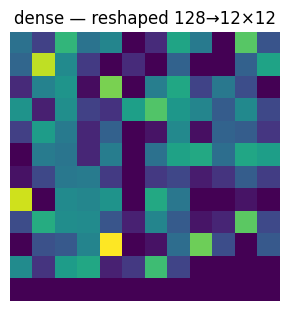


Layer: dropout (Dropout)  shape: (128,)
  stats: min 0.0000, max 0.1126, mean 0.0348


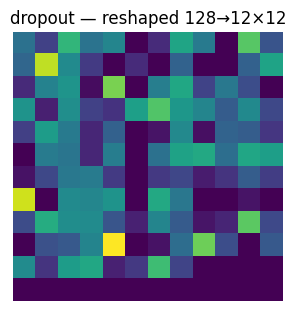


Layer: dense_1 (Dense)  shape: (64,)
  stats: min 0.0000, max 0.8202, mean 0.3535


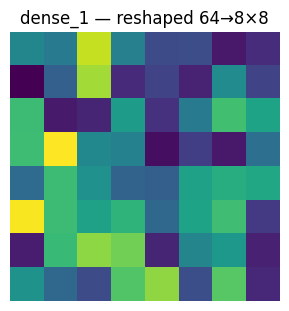


Layer: dense_2 (Dense)  shape: (10,)
  stats: min 0.0008, max 0.7184, mean 0.1000


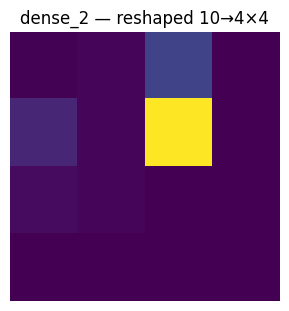

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Predicted class: 1  True label: 6


In [38]:
# Visualize Dense activations (bar + patch) for layers that are 1D after batch removed
for (name, typ, shp), act in zip(layer_infos, activations):
    # remove batch dim if present
    if act.shape[0] == 1:
        a = act[0]
    else:
        a = act

    # Only plot for vector-like activations (1D) or small 2D
    if a.ndim == 1:
        print(f"\nLayer: {name} ({typ})  shape: {a.shape}")
        print(f"  stats: min {a.min():.4f}, max {a.max():.4f}, mean {a.mean():.4f}")
        # plot_vec(a, title=name)
        plot_patch_from_vector(a, title=name)
    elif a.ndim == 2 and a.shape[0] <= 50 and a.shape[1] <= 512:
        # e.g., (timesteps, units) or small 2D activations: show heatmap
        plt.figure(figsize=(6,3))
        plt.imshow(a, aspect='auto', cmap='viridis')
        plt.title(f"{name} heatmap (2D) shape={a.shape}")
        plt.colorbar(shrink=0.6)
        plt.show()
    else:
        # skip heavy activations to keep output readable (you can change this)
        print(f"Skipping detailed plot for {name} with activation shape {a.shape} (too large to display)")

# final prediction (optional)
pred = model.predict(sample).argmax(axis=1)
print("\nPredicted class:", int(pred[0]), " True label:", int(y_test[sample_idx]))


What these images mean (general)

We visualized Dense-layer activations by taking each layer’s activation vector for one input, then reshaping that 1-D vector into a small square (nearest perfect square) and plotting it as a heatmap (Viridis colormap).

 That’s a purely visualization trick — Dense layers have no spatial structure, so the reshaping is only for human-friendly display.

Color convention you used:

dark/purple = low/near-zero activation,

green/teal = medium,

yellow = large/high activation.

dense_5 — reshaped 10 → 4×4

This is the final output layer (10 units for 10 MNIST classes) reshaped into a 4×4 grid.

You see one bright yellow square and everything else dark. That’s expected: the network strongly activates one output neuron (the predicted class) and the other output neurons are low — so the visualization becomes a single hotspot.

Takeaway: this confirms a confident prediction (one output neuron much larger than others).